<a href="https://colab.research.google.com/github/ellenmatt/DD2365-aflum/blob/main/Project/Project_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Navier-Stokes equations**
**Johan Hoffman**

# **About the code**

In [19]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [1]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time as tajm

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

--2024-05-17 07:35:50--  https://fem-on-colab.github.io/releases/fenics-install-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4161 (4.1K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   4.06K  --.-KB/s    in 0s      

2024-05-17 07:35:51 (35.3 MB/s) - ‘/tmp/fenics-install.sh’ saved [4161/4161]

+ INSTALL_PREFIX=/usr/local
++ awk -F/ '{print NF-1}'
++ echo /usr/local
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/fcd3a71/releases/pybind11-inst

# **Method**

In [21]:
# KTH houses
# house_right_up = house(4.2, 2.3, 4.5, 3.5)
# house_right_down = house(4.2, 0.2, 4.5, 1.8)
# house_small_down = house(3.7, 0.2, L-0.8, 0.5)
# house_small = house(3, 0.2, 3.3, 1.2)
# house3 = house(1.5, 0.8, 3.2, 1.2)
# house4 = house(3.9, 0.9, 4.2, 1.2)

# house5 = house(1.5, 3.1, 3.5, 3.5)
# house6 = house(4, 3.1, 4.2, 3.5)

# h_square_down = house(0.7, 0.8, 1.5, 1.5)
# h_square_up = house(0.7, 2.7, 1.5, 3.5)

# valv_h1 = house(0.9, 1.5, 1.3, 1.7)
# valv_h2 = house(0.9, 2.5, 1.3, 2.7)


# houses = house_right_down + house_right_up + house_small_down + house_small + house3 + house4 + house5 + house6 + h_square_down + h_square_up + valv_h1 + valv_h2

In [22]:
def house(x1, y1, x2, y2):
  vertices = [Point(x1, y1), Point(x2, y2)]
  return Rectangle(Point(x1, y1), Point(x2, y2))

**Define domain and mesh**

In [2]:
# Define rectangular domain
L = 30
H = 20

# Define subdomains (for boundary conditions)
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0)

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], L)

class Lower(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)

class Upper(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], H)

left = Left()
right = Right()
lower = Lower()
upper = Upper()

# Generate mesh (examples with and without a hole in the mesh)
resolution = 32

In [3]:
def PlaceHouse(shape, offsetX, offsetY, scaleX, scaleY):
  vertices = []
  for i in range(0, len(shape)):
    vertices.append( Point(shape[i][0] * scaleX + offsetX, shape[i][1] * scaleY + offsetY) )
  if scaleX * scaleY < 0:
    vertices.reverse()
  return Polygon(vertices)

In [46]:
# PlaceHouse(shape, offsetX, offsetY, scaleX, scaleY)
# for i in range(0, 5):
#   houses += PlaceHouse(shape, 12 - i, 2 + 2 * i, 0.5)
meshoff = 3

shape1 = [[1.8, 1], [-1, 1], [-1, -1], [0.1, -1], [2.2, 0.4]]
house1 = PlaceHouse(shape1, 3, 12 + meshoff, 1, 1)

shape2 = [[0, 1], [-1, 1], [-1, -1.5], [0.8, -1.5], [0.8, 0.3]]
house2 = PlaceHouse(shape2, 3, 9 + meshoff, 1, 1)

shape3 = [[1, 1], [-1, 1], [-1, -1], [1, -1]]
house3 = PlaceHouse(shape3, 3, 5 + meshoff, 1, 1)

shape4 = [[1, 1], [-1, 1], [-1, -1], [1, -1]]
house4 = PlaceHouse(shape4, 3, 2 + meshoff, 1, 1)

shape5 = [[-0.1, 0.2], [1.3, -1.2], [1.6, -1], [1.7, -0.6], [0.8, 1]]
house5 = PlaceHouse(shape5, 4, 10.3 + meshoff, 2, 1.5)

shape6 = [[0, 1.3], [0, 0], [1.8, 0], [1.8, 0.5], [0.3, 1.3]]
house6 = PlaceHouse(shape6, 4.5, 7.55 + meshoff, 1, 1)

shape7 = [[1, 1], [-1, 1], [-1, -1], [1, -1], [1.3, 0.1]]
house7 = PlaceHouse(shape7, 5.5, 5 + meshoff, 0.9, 1)

shape8 = [[1, 1], [-1, 1], [-1, -1], [1, -1]]
house8 = PlaceHouse(shape8, 5.5, 2 + meshoff, 0.9, 1.2)

shape9 =[[0, 0], [4, 0], [4.3, 0.7], [-0.3, 0.7]]
house9 = PlaceHouse(shape9, 6.2, 12.35 + meshoff, 1.5, 1)

shape10 =[[0, 0], [4, 0], [4.3, 0.7], [-0.3, 0.7]]
house10 = PlaceHouse(shape10, 7.2, 11 + meshoff, 1, 1)

shape11 =[[0, 0], [4, 0], [4.3, 0.7], [-0.3, 0.7]]
house11 = PlaceHouse(shape11, 7.9, 9.5 + meshoff, 0.6, 1)

shape13 = [[0, 0], [2.3, 0], [2.3, 0.5], [1.3, 2], [0.2, 2], [0, 1.5]]
house13 = PlaceHouse(shape13, 7.5, 1 + meshoff, 2, 1.9)

shape14 = [[0, 0], [2, 0], [2, 2], [0, 2], [-1, 1]]
house14 = PlaceHouse(shape14, 15, 11 + meshoff, 1, 1)


shape16 = [[0, 0], [2.5, 0], [2.5, 2.5], [1.3, 2.5], [-0.2, 0.4]]
house16 = PlaceHouse(shape16, 13, 7.5 + meshoff, 1.5, 1)

# shape16 = [[0, 0], [2.5, 0], [2.5, 2.5], [1.3, 2.5], [-0.2, 0.4]]
# house16 = PlaceHouse(shape16, 12.75, 5.5 + meshoff, 1.7, 1.3)

shape17 =[[0, 0], [1.8, -3], [2.5, -3], [2.5, 0.5], [0.2, 0.5], [0.2, 0.5]]
house17 = PlaceHouse(shape17, 12, 5.3 + meshoff, 2, 1.4)



# shape15 = [[0, 0], [1.5, -1.5], [1.7, -1.3], [1.7, -0.9], [1, 1]]
shape15 = [[-0.1, 0.2], [1.3, -1.2], [1.6, -1], [1.7, -0.6], [0.8, 1]]
house15 = PlaceHouse(shape15, 14.5, 10.3 + meshoff, -2, 1.5)


houses = house1 + house2 + house3 + house4 + house5 + house6 + house7 + house8 + house9 + house10 + house11 +  house13 + house14 + house15+ house16 + house17

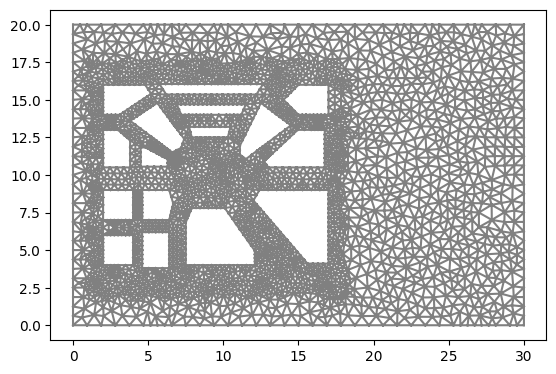

In [47]:
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H))  - houses, resolution)


no_levels = 1
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if (p[0] > 1 and p[0] < 18 and p[1] > 2 and p[1] < 17.5):
      cell_marker[cell] = True
    # if p.distance(Point(9.5, 10)) < 8.5:
    #     cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

# Define mesh functions (for boundary conditions)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundaries.set_all(0)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
lower.mark(boundaries, 3)
upper.mark(boundaries, 4)

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**

In [27]:
# Generate finite element spaces (for velocity and pressure)
V = VectorFunctionSpace(mesh, "Lagrange", 1)
Q = FunctionSpace(mesh, "Lagrange", 1)

# Define trial and test functions
u = TrialFunction(V)
p = TrialFunction(Q)
v = TestFunction(V)
q = TestFunction(Q)

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_4f750817ecc896f3bedcb4ff8c9f3352153b1b38

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00960684 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.454925 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representatio

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_3801828c0f66b7190a7fd5819465b3d5b34b9149

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00442266 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0189331 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

In [28]:
# K = FunctionSpace(mesh, "Discontinuous Lagrange", 0)

**Define boundary conditions**

In [29]:
# Define boundary conditions
class DirichletBoundaryLower(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0.0)

class DirichletBoundaryUpper(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], H)

class DirichletBoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0)

class DirichletBoundaryRight(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], L)

class DirichletBoundaryObjects(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and (not near(x[1], 0.0)) and (not near(x[1], H))

dbc_lower = DirichletBoundaryLower()
dbc_upper = DirichletBoundaryUpper()
dbc_left = DirichletBoundaryLeft()
dbc_right = DirichletBoundaryRight()
dbc_objects = DirichletBoundaryObjects()

uin = 0.5
bcu_in0 = DirichletBC(V.sub(0), uin, dbc_left)
bcu_in1 = DirichletBC(V.sub(1), 0.0, dbc_left)
bcu_upp0 = DirichletBC(V.sub(0), 0.0, dbc_upper)
bcu_upp1 = DirichletBC(V.sub(1), 0.0, dbc_upper)
bcu_low0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
bcu_low1 = DirichletBC(V.sub(1), 0.0, dbc_lower)
bcu_obj0 = DirichletBC(V.sub(0), 0.0, dbc_objects)
bcu_obj1 = DirichletBC(V.sub(1), 0.0, dbc_objects)

pin = Expression('5.0*fabs(sin(t))', element = Q.ufl_element(), t=0.0)
pout = 0.0
#bcp0 = DirichletBC(Q, pin, dbc_left)
bcp1 = DirichletBC(Q, pout, dbc_right)

# bcu = [bcu_in0, bcu_in1, bcu_upp0, bcu_upp1, bcu_low0, bcu_low1, bcu_obj0, bcu_obj1]
bcu = [bcu_in0, bcu_in1, bcu_upp1, bcu_low1, bcu_obj0, bcu_obj1]
bcp = [bcp1]

# Vind nedifrån
# bcp_upper = DirichletBC(Q, pout, dbc_upper)
# bcu_inx = DirichletBC(V.sub(0), 0.0, dbc_lower)
# bcu_iny = DirichletBC(V.sub(1), uin, dbc_lower)
# bcu_right = DirichletBC(V.sub(0), 0.0, dbc_right)
# bcu_left = DirichletBC(V.sub(0), 0.0, dbc_left)

# bcu = [bcu_inx, bcu_iny, bcu_right, bcu_left, bcu_obj0, bcu_obj1]
# bcp = [bcp_upper]

# Define measure for boundary integration
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

In [30]:
# Set permeability matrix
# Kinv11 = Expression('100.0*fabs(sin(2.0*pi*(x[1] - 0.1*x[0])))', element = K.ufl_element())
# Kinv11 = Expression('100.0*exp(-((x[0]-2.5)*(x[0]-2.5) + (x[1]-2.0)*(x[1]-2.0))/0.06)', element = K.ufl_element())
# Kinv12 = Expression('0.0', element = K.ufl_element())
# Kinv21 = Kinv12
# Kinv22 = Kinv11

# **Results**

**Define flow parameters**

In [31]:
# # Set viscosity
nu = 4.0e-3

#  --- Från Brinkman ---
# Set viscosity
# nu = 1.0e-2

# Set effective viscosity
# nueff = 1.0e-2

**Define method parameters**

In [32]:
# Define iteration functions
# (u0,p0) solution from previous time step
# (u1,p1) linearized solution at present time step
u0 = Function(V)
u1 = Function(V)
p0 = Function(Q)
p1 = Function(Q)

# Set parameters for nonlinear and lienar solvers
num_nnlin_iter = 5
prec = "amg" if has_krylov_solver_preconditioner("amg") else "default"

# Time step length
dt = 0.5*mesh.hmin()

**Define variational problem**

In [33]:
# Define variational problem

# Stabilization parameters
h = CellDiameter(mesh);
u_mag = sqrt(dot(u1,u1))
d1 = 1.0/sqrt((pow(1.0/dt,2.0) + pow(u_mag/h,2.0)))
d2 = h*u_mag

# Mean velocities for trapozoidal time stepping
um = 0.5*(u + u0)
um1 = 0.5*(u1 + u0)

# Momentum variational equation on residual form
Fu = inner((u - u0)/dt + grad(um)*um1, v)*dx - p1*div(v)*dx + nu*inner(grad(um), grad(v))*dx \
    + d1*inner((u - u0)/dt + grad(um)*um1 + grad(p1), grad(v)*um1)*dx + d2*div(um)*div(v)*dx

# Brinkman
# Fu = inner((u - u0)/dt + grad(um)*um1, v)*dx - p1*div(v)*dx + nueff*inner(grad(um), grad(v))*dx \
#     + d1*inner((u - u0)/dt + grad(um)*um1 + grad(p1), grad(v)*um1)*dx + d2*div(um)*div(v)*dx \
#     + nu*(Kinv11*inner(um[0],v[0])*dx + Kinv12*inner(um[0],v[1])*dx + Kinv21*inner(um[1],v[0])*dx + Kinv22*inner(um[1],v[1])*dx)

au = lhs(Fu)
Lu = rhs(Fu)

# Continuity variational equation on residual form
Fp = d1*inner((u1 - u0)/dt + grad(um1)*um1 + grad(p), grad(q))*dx + div(um1)*q*dx
ap = lhs(Fp)
Lp = rhs(Fp)

**Set plotting variables and open export files**

In [34]:
# Open files to export solution to Paraview
file_u = File("results-NS/u.pvd")
file_p = File("results-NS/p.pvd")

# Set plot frequency
plot_time = 0
plot_freq = 10


time = np.array(0.0)
time = np.delete(time, 0)
start_sample_time = 1.0

**Time stepping algorithm**

rm: cannot remove 'results-NS/*': No such file or directory
Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_9734b91e8659461c80e9e617a75cd0334d1177a9

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    2
  Coefficients:              '[f_664, f_667]'
  Unique elements:           'Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 10
INFO:FFC:  quadrature_degree: 10
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.166142 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:--------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_899f792bca9deb3c3f12f5cb62d42f0545d411ea

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00524783 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0166123 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_79dd4099c4e669212673d783637297ee756e6a33

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00501394 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0232942 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling coordinate_mapping ffc_coordinate_mapping_66170f427fb7c9d9caadb39d728b0be317507df5

INFO:FFC:Compiler stage 1: Analyzing coordinate_mapping(s)
INFO:FFC:-------------------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00926042 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 0 elements
INFO:FFC:  Computing representation of 0 dofmaps
INFO:FFC:  Computing representation of 1 coordinate mappings
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.017009 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:--------------------------------------------------------
INFO:

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_e5caa0d1c2c32f03eb5cde24f6a856912330c633

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    3
  Coefficients:              '[f_664, f_667, f_673]'
  Unique elements:           'Vector<2 x CG1(?,?)>, CG1(?,?)'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 10
INFO:FFC:  quadrature_degree: 10
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0646293 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_25a9b5224c0f8fce7a4815465ff4e7816b41102e

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_667]'
  Unique elements:           'CG1(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 8
INFO:FFC:  quadrature_degree: 8
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0421598 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_73bd24879958abd1edb7a8d22ce1d6480f2ef83a

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    2
  Coefficients:              '[f_664, f_667]'
  Unique elements:           'CG1(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 9
INFO:FFC:  quadrature_degree: 9
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0550673 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:----------------------

Time t = 0.13091913532671462


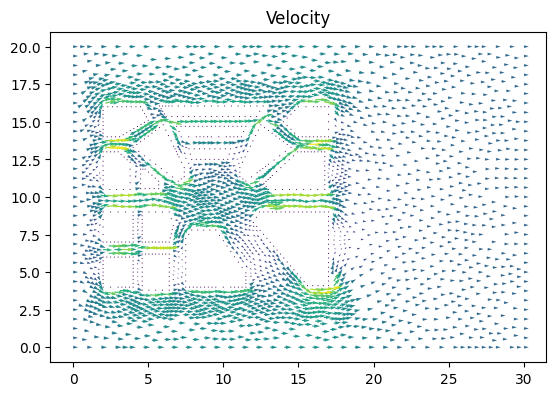

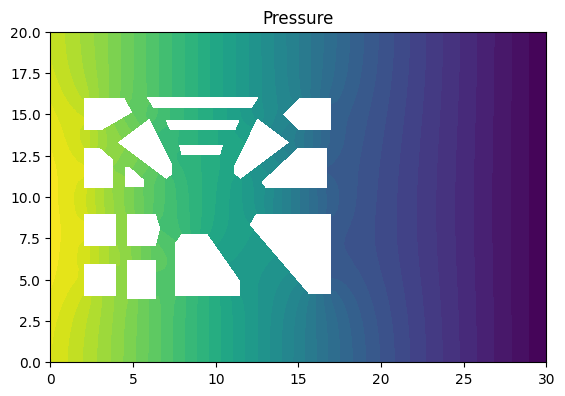

Time t = 3.011140112514438


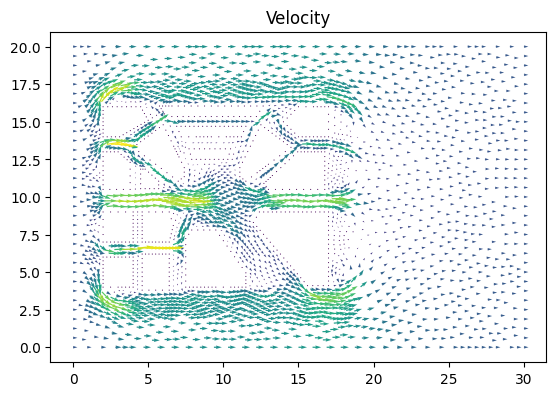

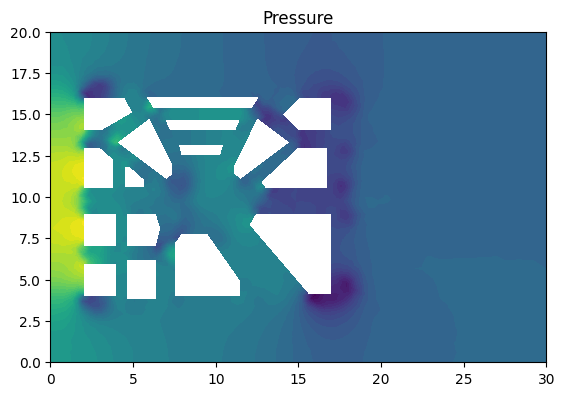

Time t = 6.022280225028877


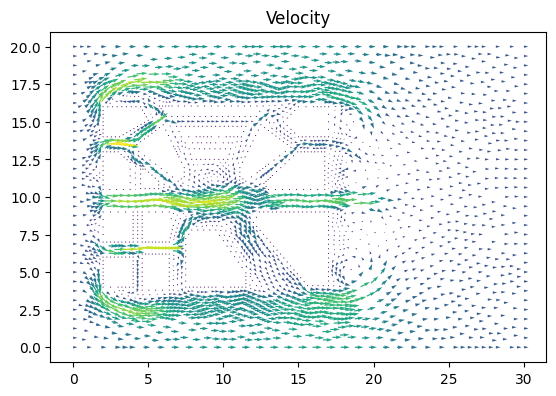

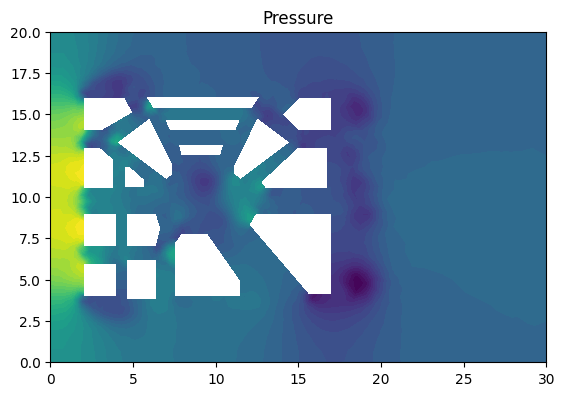

Time t = 9.033420337543308


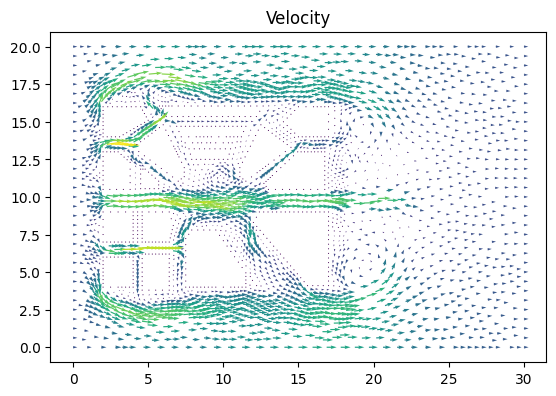

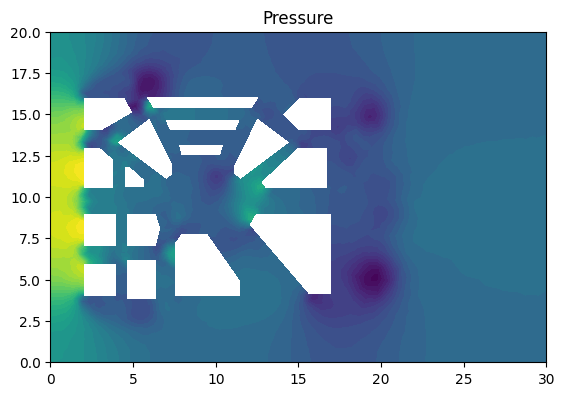

Time t = 12.044560450057727


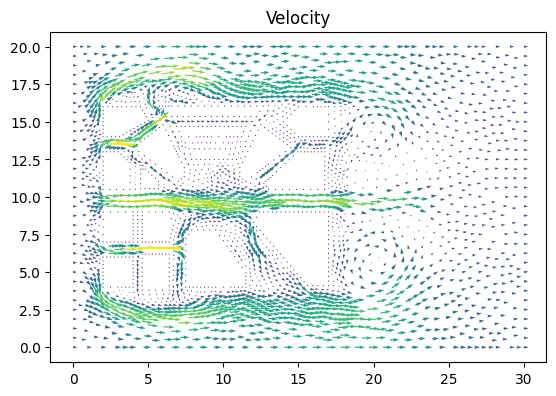

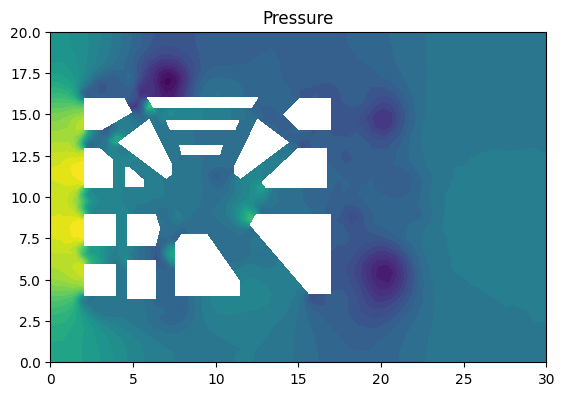

Time t = 15.055700562572145


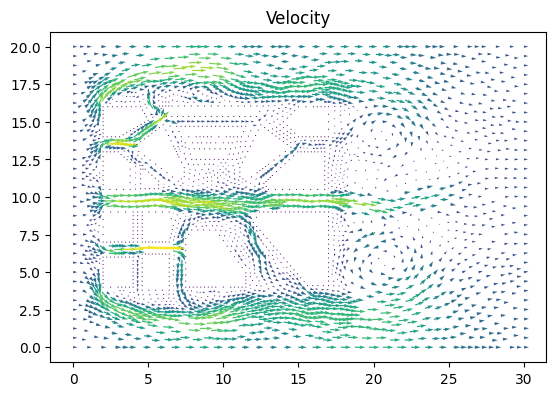

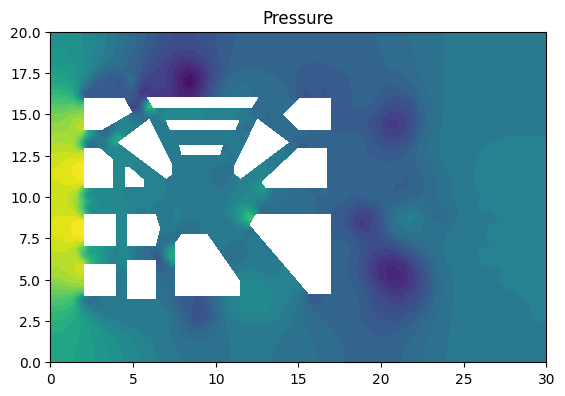

Time t = 18.066840675086564


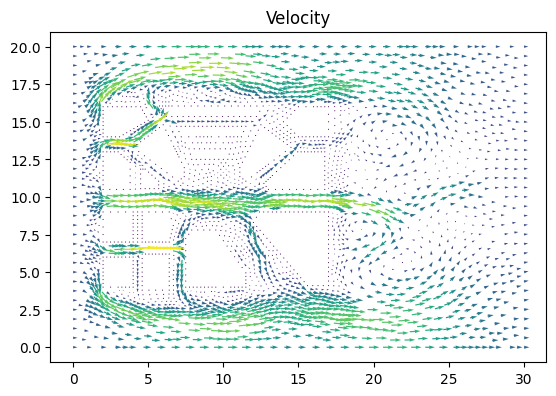

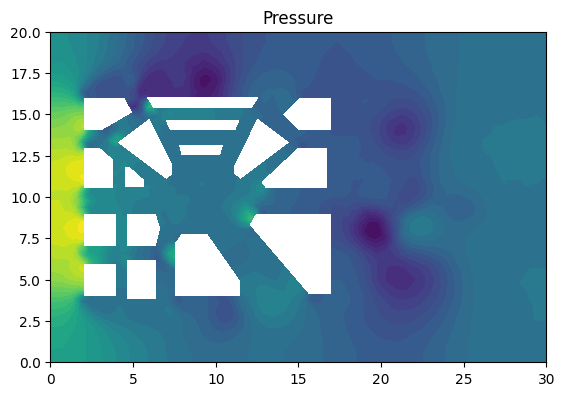

Time t = 21.077980787600982


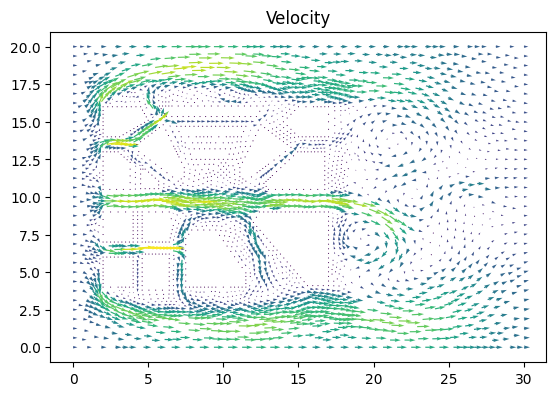

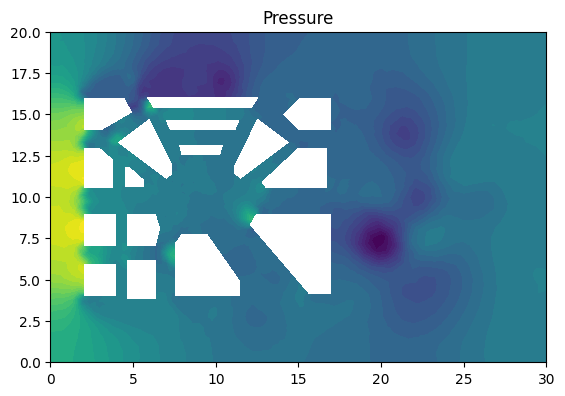

Time t = 24.0891209001154


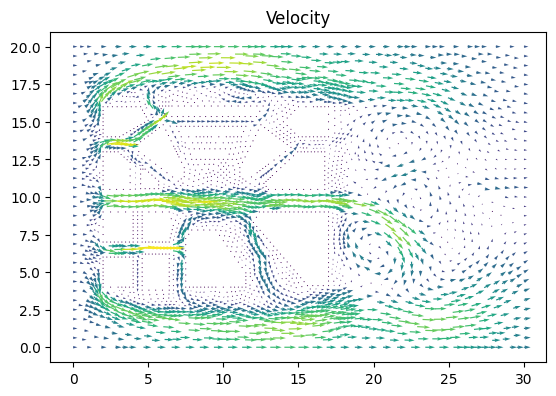

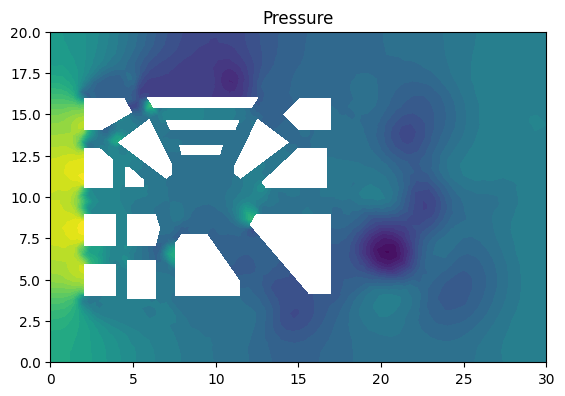

Time t = 27.10026101262982


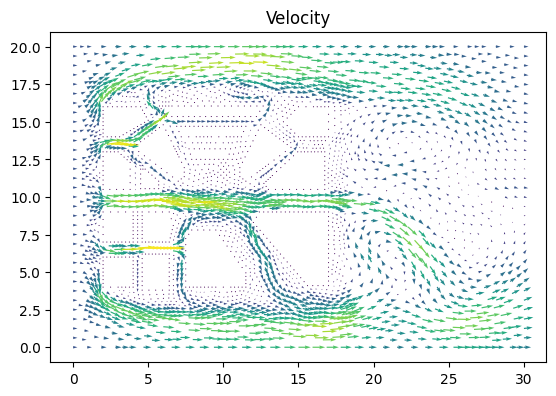

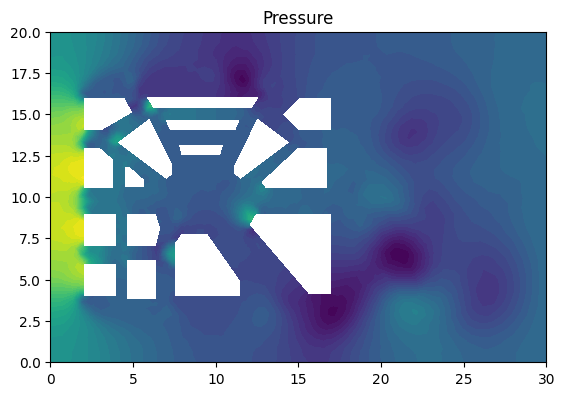

Time elapsed:  2.121092947324117 minutes
results-NS/
results-NS/p000008.vtu
results-NS/p000001.vtu
results-NS/p000000.vtu
results-NS/p.pvd
results-NS/u000002.vtu
results-NS/p000007.vtu
results-NS/p000002.vtu
results-NS/p000006.vtu
results-NS/u000008.vtu
results-NS/u000001.vtu
results-NS/u000003.vtu
results-NS/u000005.vtu
results-NS/p000003.vtu
results-NS/u000006.vtu
results-NS/u.pvd
results-NS/p000004.vtu
results-NS/u000009.vtu
results-NS/p000005.vtu
results-NS/p000009.vtu
results-NS/u000004.vtu
results-NS/u000000.vtu
results-NS/u000007.vtu


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [35]:
!rm results-NS/*

# Time stepping
T = 30
# T = 15
t = dt
start = tajm.time()
while t < T + DOLFIN_EPS:

    #s = 'Time t = ' + repr(t)
    #print(s)

    pin.t = t
    #uin.t = t

    # Solve non-linear problem
    k = 0
    while k < num_nnlin_iter:

        # Assemble momentum matrix and vector
        Au = assemble(au)
        bu = assemble(Lu)

        # Compute velocity solution
        [bc.apply(Au, bu) for bc in bcu]
        [bc.apply(u1.vector()) for bc in bcu]
        solve(Au, u1.vector(), bu, "bicgstab", "default")

        # Assemble continuity matrix and vector
        Ap = assemble(ap)
        bp = assemble(Lp)

        # Compute pressure solution
        [bc.apply(Ap, bp) for bc in bcp]
        [bc.apply(p1.vector()) for bc in bcp]
        solve(Ap, p1.vector(), bp, "bicgstab", prec)


        if (t > start_sample_time):
          time = np.append(time, t)

        k += 1

    if t > plot_time:

        s = 'Time t = ' + repr(t)
        print(s)

        # Save solution to file
        file_u << u1
        file_p << p1

        # Plot solution
        plt.figure()
        plot(u1, title="Velocity")

        plt.figure()
        plot(p1, title="Pressure")


        plot_time += T/plot_freq

        plt.show()

    # Update time step
    u0.assign(u1)
    t += dt

end = tajm.time()
print("Time elapsed: ", str((end - start)/60), "minutes")

!tar -czvf results-NS.tar.gz results-NS
files.download('results-NS.tar.gz')